# Extreme Gradient Boosting with XGBoost by Ninh Nguyen

In [1]:
#import packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


In [2]:
# read the data
customer = pd.read_excel('Customers.xlsx')
customer


,ID,Sex,Status,Children,Est_Income,Car_Owner,Usage,Age,RatePlan,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,CHURN
0,1,F,S,1,38000.00,N,229.64,24.393333,3,23.56,0.00,206.08,0,CC,Budget,Intnl_discount,Cancelled
1,6,M,M,2,29616.00,N,75.29,49.426667,2,29.78,0.00,45.50,0,CH,FreeLocal,Standard,Current
2,8,M,M,0,19732.80,N,47.25,50.673333,3,24.81,0.00,22.44,0,CC,FreeLocal,Standard,Current
3,11,M,S,2,96.33,N,59.01,56.473333,1,26.13,0.00,32.88,1,CC,Budget,Standard,Current
4,14,F,M,2,52004.80,N,28.14,25.140000,1,5.03,0.00,23.11,0,CH,Budget,Intnl_discount,Cancelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,3821,F,S,0,78851.30,N,29.04,48.373333,4,0.37,0.00,28.66,0,CC,FreeLocal,Standard,Cancelled
2066,3822,F,S,1,17540.70,Y,36.20,62.786667,1,22.17,0.57,13.45,0,Auto,Budget,Standard,Cancelled
2067,3823,F,M,0,83891.90,Y,74.40,61.020000,4,28.92,0.00,45.47,0,CH,Budget,Standard,Cancelled
2068,3824,F,M,2,28220.80,N,38.95,38.766667,4,26.49,0.00,12.46,0,CC,FreeLocal,Standard,Cancelled


In [3]:
#convert object or categorical variables to numeric
customer = pd.get_dummies(customer,columns=['Sex','Status','Car_Owner','Paymethod','LocalBilltype','LongDistanceBilltype'],drop_first=True)
customer
                         

,ID,Children,Est_Income,Usage,Age,RatePlan,LongDistance,International,Local,Dropped,CHURN,Sex_M,Status_M,Status_S,Car_Owner_Y,Paymethod_CC,Paymethod_CH,LocalBilltype_FreeLocal,LongDistanceBilltype_Standard
0,1,1,38000.00,229.64,24.393333,3,23.56,0.00,206.08,0,Cancelled,0,0,1,0,1,0,0,0
1,6,2,29616.00,75.29,49.426667,2,29.78,0.00,45.50,0,Current,1,1,0,0,0,1,1,1
2,8,0,19732.80,47.25,50.673333,3,24.81,0.00,22.44,0,Current,1,1,0,0,1,0,1,1
3,11,2,96.33,59.01,56.473333,1,26.13,0.00,32.88,1,Current,1,0,1,0,1,0,0,1
4,14,2,52004.80,28.14,25.140000,1,5.03,0.00,23.11,0,Cancelled,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,3821,0,78851.30,29.04,48.373333,4,0.37,0.00,28.66,0,Cancelled,0,0,1,0,1,0,1,1
2066,3822,1,17540.70,36.20,62.786667,1,22.17,0.57,13.45,0,Cancelled,0,0,1,1,0,0,0,1
2067,3823,0,83891.90,74.40,61.020000,4,28.92,0.00,45.47,0,Cancelled,0,1,0,1,0,1,0,1
2068,3824,2,28220.80,38.95,38.766667,4,26.49,0.00,12.46,0,Cancelled,0,1,0,0,1,0,1,1


In [4]:
# map the original values to the new values
value_map = {'Cancelled': 1, 'Current': 0}

# map the numeric values to the new values
customer['CHURN'] = customer['CHURN'].map(value_map)
customer


,ID,Children,Est_Income,Usage,Age,RatePlan,LongDistance,International,Local,Dropped,CHURN,Sex_M,Status_M,Status_S,Car_Owner_Y,Paymethod_CC,Paymethod_CH,LocalBilltype_FreeLocal,LongDistanceBilltype_Standard
0,1,1,38000.00,229.64,24.393333,3,23.56,0.00,206.08,0,1,0,0,1,0,1,0,0,0
1,6,2,29616.00,75.29,49.426667,2,29.78,0.00,45.50,0,0,1,1,0,0,0,1,1,1
2,8,0,19732.80,47.25,50.673333,3,24.81,0.00,22.44,0,0,1,1,0,0,1,0,1,1
3,11,2,96.33,59.01,56.473333,1,26.13,0.00,32.88,1,0,1,0,1,0,1,0,0,1
4,14,2,52004.80,28.14,25.140000,1,5.03,0.00,23.11,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,3821,0,78851.30,29.04,48.373333,4,0.37,0.00,28.66,0,1,0,0,1,0,1,0,1,1
2066,3822,1,17540.70,36.20,62.786667,1,22.17,0.57,13.45,0,1,0,0,1,1,0,0,0,1
2067,3823,0,83891.90,74.40,61.020000,4,28.92,0.00,45.47,0,1,0,1,0,1,0,1,0,1
2068,3824,2,28220.80,38.95,38.766667,4,26.49,0.00,12.46,0,1,0,1,0,0,1,0,1,1


In [5]:
# Create arrays for the features and the target: X, y
X = customer.drop(columns=['CHURN']) 
y = customer['CHURN']

# Create the training and test sets
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))


accuracy: 0.905797


In [6]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth=4)

# Fit the classifier to the training set
dt_clf_4.fit(X_train, y_train)

# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)


accuracy: 0.8091787439613527


In [7]:
# Create arrays for the features and the target: X, y
X = customer.drop(columns=['CHURN']) 
y = customer['CHURN']

# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))


   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.243720         0.009942         0.266667        0.030006
1          0.225845         0.013418         0.251691        0.038259
2          0.216425         0.020669         0.249275        0.042054
3          0.190821         0.011956         0.214976        0.027557
4          0.179952         0.013234         0.209179        0.026889
0.7908212560386474


In [8]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.806462       0.011670       0.786614      0.023723
1        0.829784       0.010016       0.808036      0.025550
2        0.846863       0.010971       0.817936      0.022786
3        0.862734       0.002584       0.835565      0.017149
4        0.876287       0.001235       0.849395      0.018479
0.8493948895348256


In [9]:
house = pd.read_csv('ames_housing_trimmed_processed.csv')
house


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,1,1647,0,0,...,0,0,0,0,1,0,0,0,1,175000
1456,20,85.0,13175,6,6,1978,1,2073,1,0,...,0,1,0,0,0,0,0,0,1,210000
1457,70,66.0,9042,7,9,1941,1,2340,0,0,...,0,0,0,0,1,0,0,0,1,266500
1458,20,68.0,9717,5,6,1950,1,1078,1,0,...,0,1,0,0,0,0,0,0,1,142125


In [10]:
X = house.drop(columns=['SalePrice'])
y = house['SalePrice']


In [11]:
# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 28106.463641


In [12]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))


RMSE: 40395.930815


In [13]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))


   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.533478      429.451090   142980.434934    1193.795492
1    102832.547530      322.472076   104891.395389    1223.157368
2     75872.617039      266.474211    79478.938743    1601.345019
3     57245.651780      273.624239    62411.921348    2220.150063
4     44401.298519      316.423620    51348.279619    2963.378136
4    51348.279619
Name: test-rmse-mean, dtype: float64


In [14]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-mae-mean"]).tail(1))


   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.480012     668.306786  127633.999275   2404.005913
1    89770.056424     456.963854   90122.501070   2107.909841
2    63580.789280     263.405054   64278.558741   1887.567534
3    45633.156501     151.883868   46819.168555   1459.818435
4    33587.090044      86.998100   35670.647207   1140.607311
4    35670.647207
Name: test-mae-mean, dtype: float64


In [15]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, 
                             metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2","rmse"]))


Best rmse as a function of l2:
    l2          rmse
0    1  52275.357003
1   10  57746.063828
2  100  76624.627811


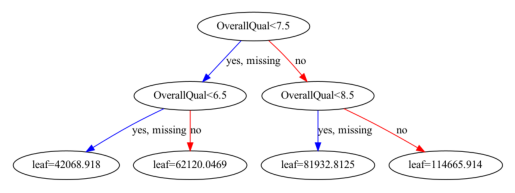

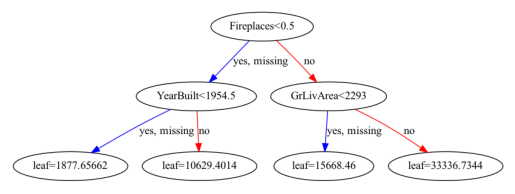

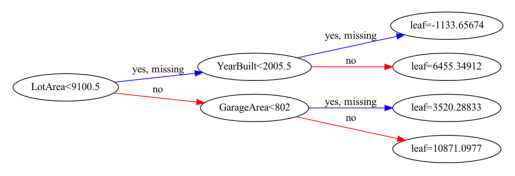

In [16]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir='LR')
plt.show()


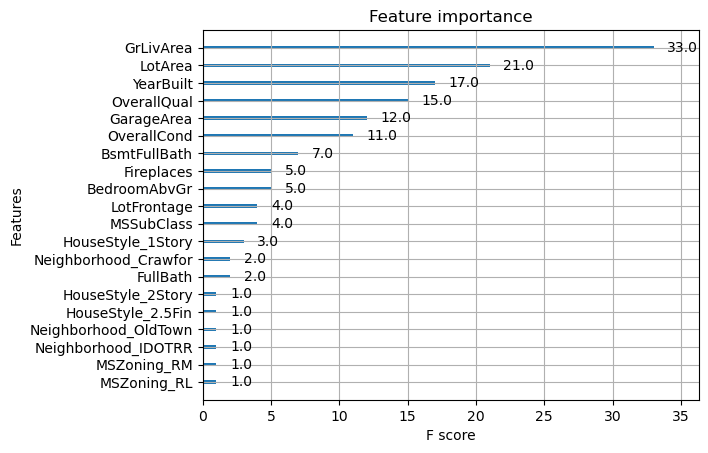

In [17]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()


In [18]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))


   num_boosting_rounds          rmse
0                    5  50903.299752
1                   10  34774.194090
2                   15  32895.099185


In [19]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     141871.635216      403.633062   142640.653507     705.559723
1     103057.033818       73.768079   104907.664683     111.117033
2      75975.967655      253.727043    79262.056654     563.766693
3      57420.530642      521.658273    61620.137859    1087.693428
4      44552.956483      544.170426    50437.560906    1846.446643
5      35763.948865      681.796675    43035.659539    2034.471115
6      29861.464164      769.571418    38600.880800    2169.796804
7      25994.675122      756.520639    36071.817710    2109.795408
8      23306.836299      759.237848    34383.186387    1934.547433
9      21459.770256      745.624640    33509.140338    1887.375358
10     20148.721060      749.612186    32916.806725    1850.893437
11     19215.382607      641.387200    32197.833474    1734.456654
12     18627.388962      716.256240    31770.852340    1802.154296
13     17960.695080      557.043324    31482.782172    1779.12

In [20]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3,
                        num_boost_round=10, early_stopping_rounds=5,
                        metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))


     eta      best_rmse
0  0.001  195736.402543
1  0.010  179932.183986
2  0.100   79759.411808


In [21]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:squarederror"}

# Create list of max_depth values
max_depths = [2, 5, 10, 20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))


   max_depth     best_rmse
0          2  37957.469464
1          5  35596.599504
2         10  36065.547345
3         20  36739.576068


In [22]:
# Create your housing DMatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))


   colsample_bytree     best_rmse
0               0.1  51386.578876
1               0.5  36585.351887
2               0.8  36093.663501
3               1.0  35836.044343


In [23]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  30355.698207097197


In [24]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
                                    n_iter=5, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 4}
Lowest RMSE found:  29998.4522530019


In [25]:
df = pd.read_csv('ames_unprocessed_data.csv')
df


,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,PavedDrive,SalePrice
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,...,1710,1,0,2,1,3,0,548,Y,208500
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,...,1262,0,1,2,0,3,1,460,Y,181500
2,60,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2001,...,1786,1,0,2,1,3,1,608,Y,223500
3,70,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1915,...,1717,1,0,1,0,3,1,642,Y,140000
4,60,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000,...,2198,1,0,2,1,4,1,836,Y,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Gilbert,1Fam,2Story,6,5,1999,...,1647,0,0,2,1,3,1,460,Y,175000
1456,20,RL,85.0,13175,NWAmes,1Fam,1Story,6,6,1978,...,2073,1,0,2,0,3,2,500,Y,210000
1457,70,RL,66.0,9042,Crawfor,1Fam,2Story,7,9,1941,...,2340,0,0,2,0,4,2,252,Y,266500
1458,20,RL,68.0,9717,NAmes,1Fam,1Story,5,6,1950,...,1078,1,0,1,0,2,0,240,Y,142125


In [26]:
# Fill missing values with 0
df.LotFrontage = df.LotFrontage.fillna(0)

# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())


  MSZoning Neighborhood BldgType HouseStyle PavedDrive
0       RL      CollgCr     1Fam     2Story          Y
1       RL      Veenker     1Fam     1Story          Y
2       RL      CollgCr     1Fam     2Story          Y
3       RL      Crawfor     1Fam     2Story          Y
4       RL      NoRidge     1Fam     2Story          Y
   MSZoning  Neighborhood  BldgType  HouseStyle  PavedDrive
0         3             5         0           5           2
1         3            24         0           2           2
2         3             5         0           5           2
3         3             6         0           5           2
4         3            15         0           5           2


In [27]:
# Create OneHotEncoder: ohe
ohe = OneHotEncoder(sparse_output=False)

# Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded
df_encoded = ohe.fit_transform(df)

# Print first 5 rows of the resulting dataset - again, this will no longer be a pandas dataframe
print(df_encoded[:5, :])

# Print the shape of the original DataFrame
print(df.shape)

# Print the shape of the transformed array
print(df_encoded.shape)


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1460, 21)
(1460, 3369)


In [28]:
# Convert df into a dictionary: df_dict
df_dict = df.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False)

# Apply dv on df: df_encoded
df_encoded = dv.fit_transform(df_dict)

# Print the resulting first five rows
print(df_encoded[:5,:])

# Print the vocabulary
print(dv.vocabulary_)


[[3.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 5.480e+02
  1.710e+03 1.000e+00 5.000e+00 8.450e+03 6.500e+01 6.000e+01 3.000e+00
  5.000e+00 5.000e+00 7.000e+00 2.000e+00 0.000e+00 2.085e+05 2.003e+03]
 [3.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00 4.600e+02
  1.262e+03 0.000e+00 2.000e+00 9.600e+03 8.000e+01 2.000e+01 3.000e+00
  2.400e+01 8.000e+00 6.000e+00 2.000e+00 0.000e+00 1.815e+05 1.976e+03]
 [3.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00 6.080e+02
  1.786e+03 1.000e+00 5.000e+00 1.125e+04 6.800e+01 6.000e+01 3.000e+00
  5.000e+00 5.000e+00 7.000e+00 2.000e+00 1.000e+00 2.235e+05 2.001e+03]
 [3.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 6.420e+02
  1.717e+03 0.000e+00 5.000e+00 9.550e+03 6.000e+01 7.000e+01 3.000e+00
  6.000e+00 5.000e+00 7.000e+00 2.000e+00 1.000e+00 1.400e+05 1.915e+03]
 [4.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00 8.360e+02
  2.198e+03 1.000e+00 5.000e+00 1.426e+04 8.400e+01 6.000e+0

In [29]:
# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor())]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Fit the pipeline
xgb_pipeline.fit(X.to_dict("records"), y)


Pipeline(steps=[('ohe_onestep', DictVectorizer(sparse=False)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [30]:
# Fill LotFrontage missing values with 0
X.LotFrontage = X.LotFrontage.fillna(0)

# Setup the pipeline steps: steps
steps = [("ohe_onestep", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor(max_depth=2, objective="reg:squarederror"))]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Cross-validate the model
cross_val_scores = cross_val_score(xgb_pipeline, X.to_dict("records"), y, cv=10, scoring="neg_mean_squared_error")

# Print the 10-fold RMSE
print("10-fold RMSE: ", np.mean(np.sqrt(np.abs(cross_val_scores))))


10-fold RMSE:  27840.01103862237
